In [1]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures, LargestConnectedComponents, RandomNodeSplit
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt 
import networkx as nx
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.utils import to_dense_adj
import numpy as np

import sys  
sys.path.append('../Selection/constraint')
from GCN_model import *
from op_const import *

In [2]:
dataset = Planetoid(root='data/Planetoid', name='Cora', pre_transform=LargestConnectedComponents(),\
    transform=NormalizeFeatures())
data = dataset[0]

Processing...
Done!


In [53]:
train_mask = np.random.rand(data.num_nodes) <= 0.6
test_mask = (1-train_mask) != 0
train_mask = torch.tensor(train_mask)
test_mask = torch.tensor(test_mask)

In [56]:
train_test_model(data, num_features=dataset.num_features, hidden_channels=16, num_classes=dataset.num_classes, 
      epochs=100, lr=1e-2, weight_decay=5e-4, train_mask=train_mask, test_mask=test_mask)

Epoch: 001, Loss: 1.9369
Epoch: 011, Loss: 1.8276
Epoch: 021, Loss: 1.7460
Epoch: 031, Loss: 1.6591
Epoch: 041, Loss: 1.5784
Epoch: 051, Loss: 1.4649
Epoch: 061, Loss: 1.3597
Epoch: 071, Loss: 1.2619
Epoch: 081, Loss: 1.2049
Epoch: 091, Loss: 1.1070
Final accuracy on test set is : 0.775


0.774863387978142

In [4]:
A = to_dense_adj(data.edge_index).reshape(data.num_nodes,data.num_nodes) # N*N
G = to_networkx(data, to_undirected=True) 
dic = dict(nx.all_pairs_shortest_path_length(G))

In [5]:
T = torch.zeros_like(A)
for i in range(T.shape[0]):
    for j in range(T.shape[1]):
        T[i,j] = dic[i][j]

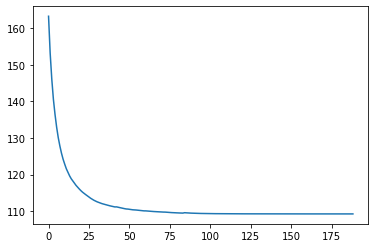

In [58]:
W, loss_rec = op_const(data.x, T, r=500, epsilon=1e-3, ratio=0.5)
plt.plot(loss_rec)

In [67]:
sel_mask = torch.sum(W, dim=0) != 0
sel_train_mask = (sel_mask & train_mask)
train_test_model(data, num_features=dataset.num_features, hidden_channels=16, num_classes=dataset.num_classes, 
      epochs=100, lr=1e-2, weight_decay=5e-4, train_mask=sel_train_mask, test_mask=test_mask)

Epoch: 001, Loss: 1.9352
Epoch: 011, Loss: 1.8064
Epoch: 021, Loss: 1.7027
Epoch: 031, Loss: 1.6164
Epoch: 041, Loss: 1.5273
Epoch: 051, Loss: 1.4201
Epoch: 061, Loss: 1.3204
Epoch: 071, Loss: 1.1861
Epoch: 081, Loss: 1.1188
Epoch: 091, Loss: 1.0157
Final accuracy on test set is : 0.708


0.7081967213114754

In [68]:
train_mask.sum()

tensor(1530)

In [69]:
sel_train_mask.sum()

tensor(320)